In [103]:
pip install seaborn tqdm xgboost pandas_datareader

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'd:\Document files\Tai lieu hoc tap\KHTN\N\CNM\deadlines\machine-learning\venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [104]:
# 1.
"""
Thay vì cố gắng xây dựng một mô hình tốt duy nhất, chúng ta sẽ xây dựng một họ các mô hình yếu hơn một chút, 
nhưng khi kết hợp các mô hình lại, (nếu có thể kết hợp một cách chính xác) sẽ thu được một mô hình còn vượt trội hơn cả.
Boosting (Mục tiêu là giảm bias - áp dụng cho các model có variance thấp và bị bias cao): 
Xây dựng một lượng lớn các model (thường là cùng loại). 
Mỗi model sau sẽ học cách sửa những errors của model trước (dữ liệu mà model trước dự đoán sai) 
--> tạo thành một chuỗi các model mà model sau sẽ tốt hơn model trước bởi trọng số được update qua mỗi model 
(cụ thể ở đây là trọng số của những dữ liệu dự đoán đúng sẽ không đổi, còn trọng số của những dữ liệu dự đoán sai 
sẽ được tăng thêm) . Chúng ta sẽ lấy kết quả của model cuối cùng trong chuỗi model này làm kết quả trả về.
"""

#2.
"""
 ==>  Ý tưởng cơ bản là Boosting sẽ tạo ra một loạt các model yếu, học bổ sung lẫn nhau. 
 ==> Nói cách khác, trong Boosting, các model sau sẽ cố gắng học để hạn chế lỗi lầm của các model trước.
"""

# 3. 
"""
Vậy làm thể nào để hạn chế được sai lầm từ các model trước ? 
Boosting tiến hành đánh trọng số cho các mô hình mới được thêm vào dựa trên các cách tối ưu khác nhau. 
Tùy theo cách đánh trọng số (cách để các model được fit một cách tuần tự) và cách tổng hợp lại các model, 
từ đó hình thành nên 2 loại Boosting :
+ Adaptive Boosting (AdaBoost)
+ Gradient Boosting
"""

# 4.
"""
#  XGBoost là viết tắt của "Extreme Gradient Boosting" và nó là một triển khai của thuật toán cây tăng cường độ dốc. 
#  XGBoost là một mô hình học máy có giám sát phổ biến với các đặc điểm như tốc độ tính toán, song song và hiệu suất
#  Đối với bài toán hồi quy, chúng ta sẽ sử dụng lớp XGBRegressor của gói xgboost
#  và chúng ta có thể xác định nó bằng các tham số mặc định của nó
"""

# 5.
"""
# --> Extreme Gradient Boosting (XGBoost) là một thư viện mã nguồn mở 
# cung cấp việc triển khai hiệu quả và hiệu quả thuật toán gradient boosting.
# Các vấn đề mô hình dự đoán hồi quy liên quan đến việc dự đoán một giá trị số như số tiền hoặc chiều cao. 
# XGBoost có thể được sử dụng trực tiếp cho mô hình dự báo hồi quy (regression predictive modeling).
"""


# 6. Hai lý do chính để sử dụng XGBoost là tốc độ thực thi và hiệu suất mô hình ?
# XGBoost thống trị các bộ dữ liệu có cấu trúc hoặc dạng bảng về các vấn đề mô hình dự đoán hồi quy và phân loại.


# 7. Tham khảo : 
# https://towardsdatascience.com/predicting-weekly-hotel-cancellations-with-xgbregressor-d73eb74a8624
"""
# An XGBRegressor model is defined as follows:
# from xgboost import XGBRegressor
# model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
# model.fit(X_train, Y_train)
"""

import math
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import time

from datetime import date, datetime
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from xgboost import XGBRegressor


# %matplotlib inline
# tham khảo: 
# https://towardsdatascience.com/predicting-weekly-hotel-cancellations-with-xgbregressor-d73eb74a8624
# https://www.datatechnotes.com/2019/06/regression-example-with-xgbregressor-in.html 
# https://github.com/NGYB/Stocks/blob/master/StockPricePrediction/StockPricePrediction_v1c_xgboost.ipynb
# https://github.com/NGYB/Stocks/tree/master/StockPricePrediction 

"""
Đối với bài toán hồi quy, chúng ta sẽ sử dụng lớp XGBRegressor của gói xgboost và chúng ta có thể xác định 
nó bằng các tham số mặc định của nó. Bạn cũng có thể đặt các giá trị tham số mới theo đặc điểm dữ liệu của mình.
"""

test_size = 0.2                # proportion of dataset to be used as test set %TESTSIZE
cv_size = 0.2                  # proportion of dataset to be used as cross-validation set %CV_SIZE
N = 3                          # for feature at day t, we use lags from t-1, t-2, ..., t-N as features 

# XGBoost Props
n_estimators = 100             # Number of boosted trees to fit. default = 100
max_depth = 3                  # Maximum tree depth for base learners. default = 3
learning_rate = 0.1            # Boosting learning rate (xgb’s “eta”). default = 0.1
min_child_weight = 1           # Minimum sum of instance weight(hessian) needed in a child. default = 1
subsample = 1                  # Subsample ratio of the training instance. default = 1
colsample_bytree = 1           # Subsample ratio of columns when constructing each tree. default = 1
colsample_bylevel = 1          # Subsample ratio of columns for each split, in each level. default = 1
gamma = 0                      # Minimum loss reduction required to make a further partition on a leaf node of the tree. default=0

model_seed = 100

fontsize = 14
ticklabelsize = 14
####################################

In [105]:
# Tinh trung binh, do  lech chuan
def get_mov_avg_std(df, col, N):
    """
    Given a dataframe, get mean and std dev at timestep t using values from t-1, t-2, ..., t-N.
    Inputs
        df         : dataframe. Can be of any length.
        col        : name of the column you want to calculate mean and std dev
        N          : get mean and std dev at timestep t using values from t-1, t-2, ..., t-N
    Outputs
        df_out     : same as df but with additional column containing mean and std dev
    """
    mean_list = df[col].rolling(window = N, min_periods=1).mean() # len(mean_list) = len(df)
    std_list = df[col].rolling(window = N, min_periods=1).std()   # first value will be NaN, because normalized by N-1
    
    # Add one timestep to the predictions
    mean_list = np.concatenate((np.array([np.nan]), np.array(mean_list[:-1])))
    std_list = np.concatenate((np.array([np.nan]), np.array(std_list[:-1])))
    
    # Append mean_list to df
    df_out = df.copy()
    df_out[col + '_mean'] = mean_list
    df_out[col + '_std'] = std_list
    
    return df_out

# Scale du lieu
def scale_row(row, feat_mean, feat_std):
    """
    Given a pandas series in row, scale it to have 0 mean and var 1 using feat_mean and feat_std
    Inputs
        row      : pandas series. Need to scale this.
        feat_mean: mean  
        feat_std : standard deviation
    Outputs
        row_scaled : pandas series with same length as row, but scaled
    """
    # If feat_std = 0 (this happens if adj_close doesn't change over N days), 
    # set it to a small number to avoid division by zero
    feat_std = 0.001 if feat_std == 0 else feat_std
    
    row_scaled = (row-feat_mean) / feat_std
    
    return row_scaled

# get mape
def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# 
def train_pred_eval_model(X_train_scaled, \
                          y_train_scaled, \
                          X_test_scaled, \
                          y_test, \
                          col_mean, \
                          col_std, \
                          seed=100, \
                          n_estimators=100, \
                          max_depth=3, \
                          learning_rate=0.1, \
                          min_child_weight=1, \
                          subsample=1, \
                          colsample_bytree=1, \
                          colsample_bylevel=1, \
                          gamma=0):
    '''
    Train model, do prediction, scale back to original range and do evaluation
    Use XGBoost here.
    Inputs
        X_train_scaled     : features for training. Scaled to have mean 0 and variance 1
        y_train_scaled     : target for training. Scaled to have mean 0 and variance 1
        X_test_scaled      : features for test. Each sample is scaled to mean 0 and variance 1
        y_test             : target for test. Actual values, not scaled.
        col_mean           : means used to scale each sample of X_test_scaled. Same length as X_test_scaled and y_test
        col_std            : standard deviations used to scale each sample of X_test_scaled. Same length as X_test_scaled and y_test
        seed               : model seed
        n_estimators       : number of boosted trees to fit
        max_depth          : maximum tree depth for base learners
        learning_rate      : boosting learning rate (xgb’s “eta”)
        min_child_weight   : minimum sum of instance weight(hessian) needed in a child
        subsample          : subsample ratio of the training instance
        colsample_bytree   : subsample ratio of columns when constructing each tree
        colsample_bylevel  : subsample ratio of columns for each split, in each level
        gamma              : 
    Outputs
        rmse               : root mean square error of y_test and est
        mape               : mean absolute percentage error of y_test and est
        est                : predicted values. Same length as y_test
    '''

    model = XGBRegressor(seed=model_seed,
                         n_estimators=n_estimators,
                         max_depth=max_depth,
                         learning_rate=learning_rate,
                         min_child_weight=min_child_weight,
                         subsample=subsample,
                         colsample_bytree=colsample_bytree,
                         colsample_bylevel=colsample_bylevel,
                         gamma=gamma)
    
    # Train the model
    model.fit(X_train_scaled, y_train_scaled)
    
    # Get predicted labels and scale back to original range
    est_scaled = model.predict(X_test_scaled)
    est = est_scaled * col_std + col_mean

    # Calculate RMSE
    rmse = math.sqrt(mean_squared_error(y_test, est))
    mape = get_mape(y_test, est)
    
    return rmse, mape, est

```
Doc file
Xoa ki tu
```

In [106]:
# Doc file 
import pandas_datareader as web 

main_company = 'ETH-USD'

start = datetime(2010, 1, 1)

df = web.DataReader(main_company, 'yahoo', start)
df['Date']=df.index

df=df.reset_index(drop=True)
# df

# Convert Date column to datetime
df.loc[:, 'Date'] = pd.to_datetime(df['Date'],format='%Y-%m-%d')

# Change all column headings to be lower case, and remove spacing
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]

# Get month of each sample
df['month'] = df['date'].dt.month

# Sort by datetime
df.sort_values(by='date', inplace=True, ascending=True)

df.head()


,high,low,open,close,volume,adj_close,date,month
0,329.451996,307.056000,308.644989,320.884003,8.932500e+08,320.884003,2017-11-09,11
1,324.717987,294.541992,320.670990,299.252991,8.859860e+08,299.252991,2017-11-10,11
2,319.453003,298.191986,298.585999,314.681000,8.423010e+08,314.681000,2017-11-11,11
3,319.153015,298.513000,314.690002,307.907990,1.613480e+09,307.907990,2017-11-12,11
4,328.415009,307.024994,307.024994,316.716003,1.041890e+09,316.716003,2017-11-13,11


Text(0, 0.5, 'USD')

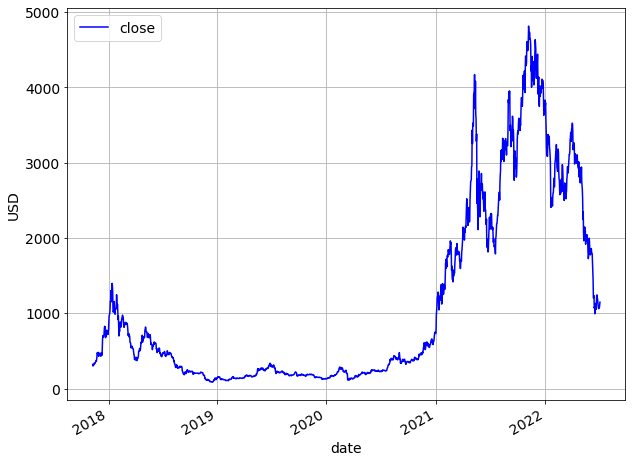

In [107]:
# Plot  close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

# Ve params
ax = df.plot(x='date', y='close', style='b-', grid=True)
ax.set_xlabel("date")
ax.set_ylabel("USD")

```
Params Date-USD
```




```

Feature Engineering
We will generate the following features:

Mean 'adj_close' of each month
Difference between high and low of each day
Difference between open and close of each day
Mean volume of each month

AverageAdjCloseByMonth
Range_HL = (High - Low)
Range_OC = (Open - Close)

Tinh Range HighLow  trong ngay
Tinh Range OpenClose trong ngay
```



In [108]:
# Get difference between high and low of each day

df['range_hl'] = df['high'] - df['low']
df.drop(['high', 'low'], axis=1, inplace=True)

# Get difference between open and close of each day
df['range_oc'] = df['open'] - df['close']
df.drop(['open', 'close'], axis=1, inplace=True)

df.head()

,volume,adj_close,date,month,range_hl,range_oc
0,8.932500e+08,320.884003,2017-11-09,11,22.395996,-12.239014
1,8.859860e+08,299.252991,2017-11-10,11,30.175995,21.417999
2,8.423010e+08,314.681000,2017-11-11,11,21.261017,-16.095001
3,1.613480e+09,307.907990,2017-11-12,11,20.640015,6.782013
4,1.041890e+09,316.716003,2017-11-13,11,21.390015,-9.691010




```

Now we use lags up to N number of days to use as features.

Them col 'ORDERDAY'
```



In [109]:
# Add a column 'order_day' to indicate the order of the rows by date
df['order_day'] = [x for x in list(range(len(df)))]
# merging_keys
merging_keys = ['order_day']

# List of columns that we will use to create lags
lag_cols = ['adj_close', 'range_hl', 'range_oc', 'volume']
lag_cols
# df.head(10)

['adj_close', 'range_hl', 'range_oc', 'volume']

In [110]:
# !jupyter nbextension enable --py widgetsnbextension

In [111]:
# Get ADJ-CLOSE,RANGEHL,RANGOC,VOLUME cua 3 ngay trc do
shift_range = [x+1 for x in range(N)]

for shift in tqdm(shift_range):
    train_shift = df[merging_keys + lag_cols].copy()
    
    # E.g. order_day of 0 becomes 1, for shift = 1.
    # So when this is merged with order_day of 1 in df, this will represent lag of 1.
    train_shift['order_day'] = train_shift['order_day'] + shift
    
    foo = lambda x: '{}_lag_{}'.format(x, shift) if x in lag_cols else x
    train_shift = train_shift.rename(columns=foo)

    df = pd.merge(df, train_shift, on=merging_keys, how='left') #.fillna(0)
    
del train_shift

# Remove the first N rows which contain NaNs
df = df[N:]
    
df.head()

100%|██████████| 3/3 [00:00<00:00, 374.92it/s]


,volume,adj_close,date,month,range_hl,range_oc,order_day,adj_close_lag_1,range_hl_lag_1,range_oc_lag_1,volume_lag_1,adj_close_lag_2,range_hl_lag_2,range_oc_lag_2,volume_lag_2,adj_close_lag_3,range_hl_lag_3,range_oc_lag_3,volume_lag_3
3,1.613480e+09,307.907990,2017-11-12,11,20.640015,6.782013,3,314.681000,21.261017,-16.095001,8.423010e+08,299.252991,30.175995,21.417999,8.859860e+08,320.884003,22.395996,-12.239014,8.932500e+08
4,1.041890e+09,316.716003,2017-11-13,11,21.390015,-9.691010,4,307.907990,20.640015,6.782013,1.613480e+09,314.681000,21.261017,-16.095001,8.423010e+08,299.252991,30.175995,21.417999,8.859860e+08
5,1.069680e+09,337.631012,2017-11-14,11,23.414001,-20.868011,5,316.716003,21.390015,-9.691010,1.041890e+09,307.907990,20.640015,6.782013,1.613480e+09,314.681000,21.261017,-16.095001,8.423010e+08
6,7.226660e+08,333.356995,2017-11-15,11,11.098999,4.606995,6,337.631012,23.414001,-20.868011,1.069680e+09,316.716003,21.390015,-9.691010,1.041890e+09,307.907990,20.640015,6.782013,1.613480e+09
7,7.972540e+08,330.924011,2017-11-16,11,12.553009,2.518982,7,333.356995,11.098999,4.606995,7.226660e+08,337.631012,23.414001,-20.868011,1.069680e+09,316.716003,21.390015,-9.691010,1.041890e+09


In [112]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1696 entries, 3 to 1698
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   volume           1696 non-null   float64       
 1   adj_close        1696 non-null   float64       
 2   date             1696 non-null   datetime64[ns]
 3   month            1696 non-null   int64         
 4   range_hl         1696 non-null   float64       
 5   range_oc         1696 non-null   float64       
 6   order_day        1696 non-null   int64         
 7   adj_close_lag_1  1696 non-null   float64       
 8   range_hl_lag_1   1696 non-null   float64       
 9   range_oc_lag_1   1696 non-null   float64       
 10  volume_lag_1     1696 non-null   float64       
 11  adj_close_lag_2  1696 non-null   float64       
 12  range_hl_lag_2   1696 non-null   float64       
 13  range_oc_lag_2   1696 non-null   float64       
 14  volume_lag_2     1696 non-null   float64

In [113]:
# Get mean and std dev at timestamp t using values from t-1, ..., t-N
# TINH TRUNG BINH, DO LECH CHUAN CUA 1 NGAY TRONG 3 NGAY QUA
cols_list = [
"adj_close",
"range_hl",
"range_oc",
"volume"
]

for col in cols_list:
    df = get_mov_avg_std(df, col, N)
df.head()

,volume,adj_close,date,month,range_hl,range_oc,order_day,adj_close_lag_1,range_hl_lag_1,range_oc_lag_1,...,range_oc_lag_3,volume_lag_3,adj_close_mean,adj_close_std,range_hl_mean,range_hl_std,range_oc_mean,range_oc_std,volume_mean,volume_std
3,1.613480e+09,307.907990,2017-11-12,11,20.640015,6.782013,3,314.681000,21.261017,-16.095001,...,-12.239014,8.932500e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.041890e+09,316.716003,2017-11-13,11,21.390015,-9.691010,4,307.907990,20.640015,6.782013,...,21.417999,8.859860e+08,307.907990,NaN,20.640015,NaN,6.782013,NaN,1.613480e+09,NaN
5,1.069680e+09,337.631012,2017-11-14,11,23.414001,-20.868011,5,316.716003,21.390015,-9.691010,...,-16.095001,8.423010e+08,312.311996,6.228206,21.015015,0.530330,-1.454498,11.648186,1.327685e+09,4.041751e+08
6,7.226660e+08,333.356995,2017-11-15,11,11.098999,4.606995,6,337.631012,23.414001,-20.868011,...,6.782013,1.613480e+09,320.751668,15.266940,21.814677,1.434923,-7.925669,13.909288,1.241683e+09,3.222850e+08
7,7.972540e+08,330.924011,2017-11-16,11,12.553009,2.518982,7,333.356995,11.098999,4.606995,...,-9.691010,1.041890e+09,329.234670,11.050093,18.634338,6.603797,-8.650675,12.769327,9.447453e+08,1.928276e+08


In [114]:

# Split into train, dev and test set
# Get sizes of each of the datasets
# TINH COUNT TRAIN, TEST, CV
num_cv = int(cv_size*len(df))
num_test = int(test_size*len(df))
num_train = len(df) - num_cv - num_test
print("num_train = " + str(num_train))
print("num_cv = " + str(num_cv))
print("num_test = " + str(num_test))

# Split into train, cv, and test
# TAO ARR TRAIN, TEST,CV
train = df[:num_train]
cv = df[num_train:num_train+num_cv]
train_cv = df[:num_train+num_cv]
test = df[num_train+num_cv:]
print("train.shape = " + str(train.shape))
print("cv.shape = " + str(cv.shape))
print("train_cv.shape = " + str(train_cv.shape))
print("test.shape = " + str(test.shape))

num_train = 1018
num_cv = 339
num_test = 339
train.shape = (1018, 27)
cv.shape = (339, 27)
train_cv.shape = (1357, 27)
test.shape = (339, 27)


In [115]:
# SCALING DU LIEU TRAIN
cols_to_scale = [
"adj_close"
]

for i in range(1,N+1):
    cols_to_scale.append("adj_close_lag_"+str(i))
    cols_to_scale.append("range_hl_lag_"+str(i))
    cols_to_scale.append("range_oc_lag_"+str(i))
    cols_to_scale.append("volume_lag_"+str(i))

# Do scaling for train set
# Here we only scale the train dataset, and not the entire dataset to prevent information leak
# Scale data for train
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train[cols_to_scale])


# Numpy --> pandas Frame
# Them date month
train_scaled = pd.DataFrame(train_scaled, columns=cols_to_scale)
train_scaled[['date', 'month']] = train.reset_index()[['date', 'month']]
# print("train_scaled.shape = " + str(train_scaled.shape))
train_scaled.head()

,adj_close,adj_close_lag_1,range_hl_lag_1,range_oc_lag_1,volume_lag_1,adj_close_lag_2,range_hl_lag_2,range_oc_lag_2,volume_lag_2,adj_close_lag_3,range_hl_lag_3,range_oc_lag_3,volume_lag_3,date,month
0,-0.041948,-0.013248,-0.054761,-0.655344,-1.059014,-0.077532,0.197232,0.872947,-1.048956,0.013518,-0.023229,-0.498809,-1.045793,2017-11-12,11
1,-0.004995,-0.041664,-0.072334,0.277680,-0.917317,-0.012800,-0.055041,-0.656761,-1.056981,-0.077245,0.196938,0.873511,-1.047127,2017-11-13,11
2,0.082750,-0.004710,-0.051110,-0.394161,-1.022341,-0.041218,-0.072614,0.276120,-0.915328,-0.012510,-0.055348,-0.656032,-1.055147,2017-11-14,11
3,0.064819,0.083039,0.006165,-0.850008,-1.017235,-0.004261,-0.051390,-0.395618,-1.020319,-0.040929,-0.072922,0.276748,-0.913565,2017-11-15,11
4,0.054612,0.065107,-0.342326,0.188973,-1.080996,0.083493,0.005884,-0.851395,-1.015215,-0.003971,-0.051697,-0.394918,-1.018504,2017-11-16,11


In [116]:
# Scaling TRAIN+DEV data
scaler_train_cv = StandardScaler()
train_cv_scaled = scaler_train_cv.fit_transform(train_cv[cols_to_scale])
# print("scaler_train_cv.mean_ = " + str(scaler_train_cv.mean_))
# print("scaler_train_cv.var_ = " + str(scaler_train_cv.var_))
# print("train_cv_scaled.shape = " + str(train_cv_scaled.shape))

# Convert the numpy array back into pandas dataframe
train_cv_scaled = pd.DataFrame(train_cv_scaled, columns=cols_to_scale)
train_cv_scaled[['date', 'month']] = train_cv.reset_index()[['date', 'month']]
# print("train_cv_scaled.shape = " + str(train_cv_scaled.shape))
train_cv_scaled.head()

,adj_close,adj_close_lag_1,range_hl_lag_1,range_oc_lag_1,volume_lag_1,adj_close_lag_2,range_hl_lag_2,range_oc_lag_2,volume_lag_2,adj_close_lag_3,range_hl_lag_3,range_oc_lag_3,volume_lag_3,date,month
0,-0.416211,-0.405501,-0.314725,-0.236206,-0.909708,-0.425950,-0.218434,0.368669,-0.904756,-0.394281,-0.301351,-0.175044,-0.902854,2017-11-12,11
1,-0.403880,-0.415007,-0.321384,0.133294,-0.843333,-0.404250,-0.314055,-0.237572,-0.908515,-0.424769,-0.217901,0.368878,-0.903479,2017-11-13,11
2,-0.374599,-0.402645,-0.313342,-0.132771,-0.892530,-0.413776,-0.320716,0.132139,-0.842156,-0.403024,-0.313525,-0.237359,-0.907238,2017-11-14,11
3,-0.380583,-0.373293,-0.291637,-0.313298,-0.890138,-0.401387,-0.312672,-0.134079,-0.891341,-0.412570,-0.320186,0.132350,-0.840888,2017-11-15,11
4,-0.383989,-0.379291,-0.423699,0.098164,-0.920005,-0.371969,-0.290963,-0.314708,-0.888949,-0.400156,-0.312142,-0.133866,-0.890066,2017-11-16,11


In [117]:
# Do scaling for dev set
cv_scaled = cv[['date']]
for col in tqdm(cols_list):
    # Tao arr
    feat_list = [col + '_lag_' + str(shift) for shift in range(1, N+1)]
    # Scaling DEV set
    temp = cv.apply(lambda row: scale_row(row[feat_list], row[col+'_mean'], row[col+'_std']), axis=1)
    # Save
    cv_scaled = pd.concat([cv_scaled, temp], axis=1)
    
# Now the entire dev set is scaled
cv_scaled.head()

100%|██████████| 4/4 [00:00<00:00,  6.16it/s]


,date,adj_close_lag_1,adj_close_lag_2,adj_close_lag_3,range_hl_lag_1,range_hl_lag_2,range_hl_lag_3,range_oc_lag_1,range_oc_lag_2,range_oc_lag_3,volume_lag_1,volume_lag_2,volume_lag_3
1021,2020-08-26,-0.849455,1.102090,-0.252634,1.070017,-0.159112,-0.910905,0.993765,-1.006120,0.012355,0.992779,0.014288,-1.007067
1022,2020-08-27,-0.482081,-0.667639,1.149720,-0.869051,1.092980,-0.223929,-0.203696,1.086165,-0.882470,-0.708005,1.143969,-0.435964
1023,2020-08-28,-0.892548,1.080717,-0.188169,-0.199282,-0.885354,1.084636,-0.327976,-0.794826,1.122802,-0.378780,-0.755276,1.134056
1024,2020-08-29,1.108072,-0.835340,-0.272733,-0.062111,1.029608,-0.967497,-1.072009,0.907618,0.164391,-1.076151,0.900600,0.175551
1025,2020-08-30,0.786470,0.338952,-1.125423,-0.996010,-0.007933,1.003943,0.030960,-1.015120,0.984161,-0.759653,-0.373297,1.132950


In [118]:
# Do scaling for test set
# Scaling TEST DEV
test_scaled = test[['date']]
for col in tqdm(cols_list):
    # Tao arr
    feat_list = [col + '_lag_' + str(shift) for shift in range(1, N+1)]
    # Scaling test dev 
    temp = test.apply(lambda row: scale_row(row[feat_list], row[col+'_mean'], row[col+'_std']), axis=1)
    # Save
    test_scaled = pd.concat([test_scaled, temp], axis=1)
    
# Now the entire test set is scaled
test_scaled.head()

100%|██████████| 4/4 [00:00<00:00,  7.22it/s]


,date,adj_close_lag_1,adj_close_lag_2,adj_close_lag_3,range_hl_lag_1,range_hl_lag_2,range_hl_lag_3,range_oc_lag_1,range_oc_lag_2,range_oc_lag_3,volume_lag_1,volume_lag_2,volume_lag_3
1360,2021-07-31,1.003102,-0.006233,-0.996869,0.950552,0.092472,-1.043024,-0.601301,-0.553064,1.154365,0.855836,-1.099229,0.243394
1361,2021-08-01,0.962158,0.071812,-1.033970,-0.403825,1.138766,-0.734941,1.120108,-0.802991,-0.317117,-0.089113,1.041574,-0.952461
1362,2021-08-02,0.818500,0.296118,-1.114618,1.046288,-0.946182,-0.100106,1.137224,-0.395286,-0.741938,1.018870,-0.979996,-0.038874
1363,2021-08-03,1.085292,-0.201169,-0.884123,0.096774,0.948095,-1.044869,0.019516,0.990099,-1.009615,0.470117,0.678310,-1.148427
1364,2021-08-04,-1.032778,0.963633,0.069145,0.794361,-1.122951,0.328590,1.146197,-0.694239,-0.451958,0.575351,-1.154698,0.579347


In [119]:
# Split into X and y
# 
features = []
for i in range(1,N+1):
    features.append("adj_close_lag_"+str(i))
    features.append("range_hl_lag_"+str(i))
    features.append("range_oc_lag_"+str(i))
    features.append("volume_lag_"+str(i))

target = "adj_close"


# Split into X and y
# TRAIN
X_train = train[features]
y_train = train[target]
# CV
X_cv = cv[features]
y_cv = cv[target]
# TRAIN_CV
X_train_cv = train_cv[features]
y_train_cv = train_cv[target]
# TEST
X_sample = test[features]
y_sample = test[target]

# Print
# print("X_train.shape = " + str(X_train.shape))
# print("y_train.shape = " + str(y_train.shape))
# print("X_cv.shape = " + str(X_cv.shape))
# print("y_cv.shape = " + str(y_cv.shape))
# print("X_train_cv.shape = " + str(X_train_cv.shape))
# print("y_train_cv.shape = " + str(y_train_cv.shape))
# print("X_sample.shape = " + str(X_sample.shape))
# print("y_sample.shape = " + str(y_sample.shape))

In [120]:

# Split into X and y
# TRAIN_SCALED
X_train_scaled = train_scaled[features]
y_train_scaled = train_scaled[target]
# CV_SCALED
X_cv_scaled = cv_scaled[features]
# TRAIN_CV_SCALED
X_train_cv_scaled = train_cv_scaled[features]
y_train_cv_scaled = train_cv_scaled[target]
# TEST
X_sample_scaled = test_scaled[features]
# PRINT
# print("X_train_scaled.shape = " + str(X_train_scaled.shape))
# print("y_train_scaled.shape = " + str(y_train_scaled.shape))
# print("X_cv_scaled.shape = " + str(X_cv_scaled.shape))
# print("X_train_cv_scaled.shape = " + str(X_train_cv_scaled.shape))
# print("y_train_cv_scaled.shape = " + str(y_train_cv_scaled.shape))
# print("X_sample_scaled.shape = " + str(X_sample_scaled.shape))

Text(0.5, 1.0, 'Without scaling')

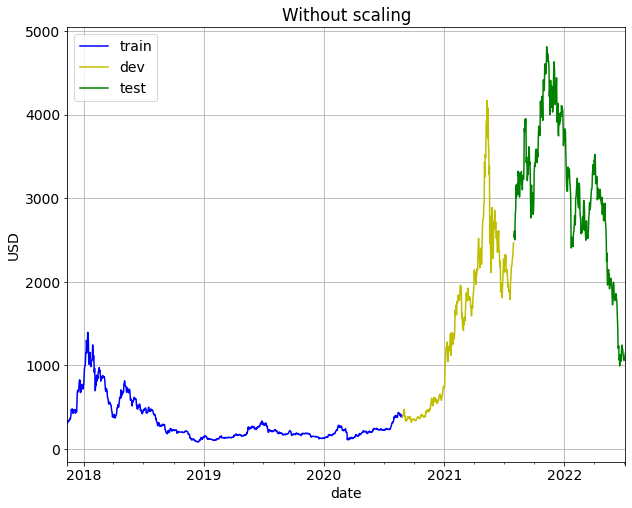

In [121]:
# EDA
# Bieu do train khong scaling
# Plot adjusted close over time

# Set props
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

# Get data hien thi
ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test'])

# Set label
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_title("Without scaling")

Text(0.5, 1.0, 'With scaling')

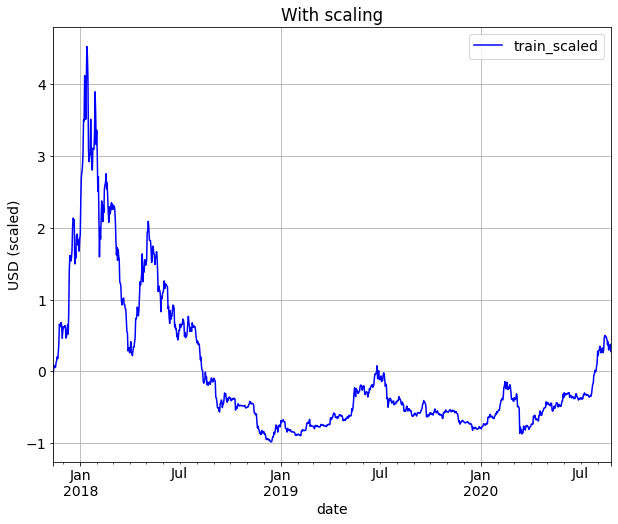

In [122]:
# Bieu do da scale for train
# Plot adjusted close over time
# Props
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

# Get data from train_scaled
ax = train_scaled.plot(x='date', y='adj_close', style='b-', grid=True)
ax.legend(['train_scaled'])
# Set label
ax.set_xlabel("date")
ax.set_ylabel("USD (scaled)")
ax.set_title("With scaling")

In [123]:
# Trrain  du lieu Train_scaled bang  XGBoost
# Create the model
model = XGBRegressor(seed=model_seed,
                     n_estimators=n_estimators,
                     max_depth=max_depth,
                     learning_rate=learning_rate,
                     min_child_weight=min_child_weight,
                     subsample=subsample,
                     colsample_bytree=colsample_bytree,
                     colsample_bylevel=colsample_bylevel,
                     gamma=gamma)

# Train the regressor
model.fit(X_train_scaled, y_train_scaled)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=100,
             reg_alpha=0, reg_lambda=1, ...)

In [124]:
# Predict on train set
# Do prediction on train set
est_scaled = model.predict(X_train_scaled)
est = est_scaled * math.sqrt(scaler.var_[0]) + scaler.mean_[0]

# Calculate RMSE
print("RMSE on train set = %0.3f" % math.sqrt(mean_squared_error(y_train, est)))

# Calculate MAPE
print("MAPE on train set = %0.3f%%" % get_mape(y_train, est))

RMSE on train set = 12.660
MAPE on train set = 2.764%


Text(0.5, 1.0, 'Without scaling')

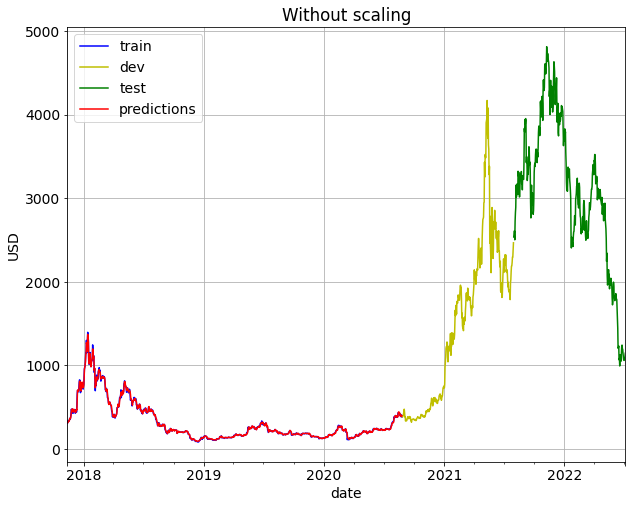

In [125]:
# Plot adjusted close over time
# PREDICT ON TRAIN
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': est, 
                       'date': train['date']})

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_title('Without scaling')

In [126]:
# Predict on dev set
# Do prediction on test set
est_scaled = model.predict(X_cv_scaled)
cv['est_scaled'] = est_scaled
cv['est'] = cv['est_scaled'] * cv['adj_close_std'] + cv['adj_close_mean']

# Calculate RMSE
rmse_bef_tuning = math.sqrt(mean_squared_error(y_cv, cv['est']))
print("RMSE on dev set = %0.3f" % rmse_bef_tuning)

# Calculate MAPE
mape_bef_tuning = get_mape(y_cv, cv['est'])
print("MAPE on dev set = %0.3f%%" % mape_bef_tuning)

RMSE on dev set = 115.048
MAPE on dev set = 4.151%


C:\Users\Hiep\AppData\Local\Temp\ipykernel_23708\3189753845.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cv['est_scaled'] = est_scaled
C:\Users\Hiep\AppData\Local\Temp\ipykernel_23708\3189753845.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cv['est'] = cv['est_scaled'] * cv['adj_close_std'] + cv['adj_close_mean']


Text(0, 0.5, 'USD')

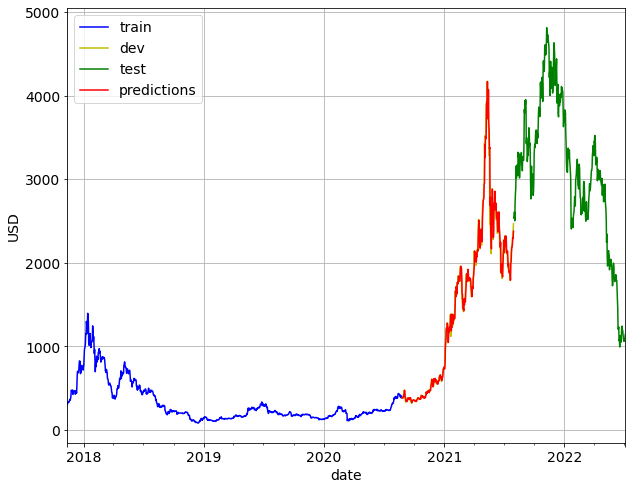

In [127]:
# PREDICT ON CV
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
# Create DataFrame
est_df = pd.DataFrame({'est': cv['est'], 
                       'y_cv': y_cv,
                       'date': cv['date']})

# Get dulieu hien thi
ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
# Du doan gia on DEV 
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)

# Set label
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

Text(0.5, 1.0, 'Zoom in to dev set')

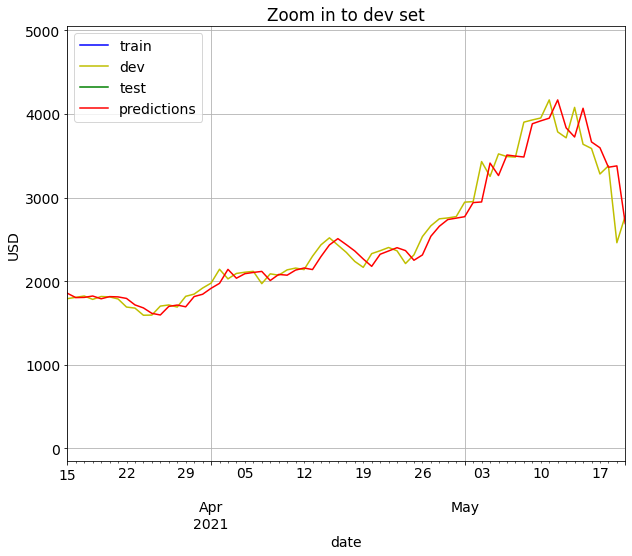

In [128]:
# ZOOM 
# Plot adjusted close over time, for dev set only
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2021, 3, 15), date(2021, 5, 20)])
ax.set_title("Zoom in to dev set")

In [129]:

# View a list of the features and their importance scores
imp = list(zip(train[features], model.feature_importances_))
imp.sort(key=lambda tup: tup[1]) 
imp[-10:]

[('range_hl_lag_2', 0.00205046),
 ('volume_lag_3', 0.002274021),
 ('range_hl_lag_1', 0.0022894205),
 ('range_oc_lag_3', 0.0024114666),
 ('adj_close_lag_3', 0.0029934845),
 ('range_oc_lag_1', 0.004245043),
 ('volume_lag_1', 0.007705069),
 ('volume_lag_2', 0.010456457),
 ('adj_close_lag_2', 0.055639543),
 ('adj_close_lag_1', 0.9062428)]

In [130]:
# Tuning N (no. of days to use as features)
d = {'N': [2, 3, 4, 5, 6, 7, 14],
     'rmse_dev_set': [1.225, 1.214, 1.231, 1.249, 1.254, 1.251, 1.498],
     'mape_pct_dev_set': [0.585, 0.581, 0.590, 0.601, 0.609, 0.612, 0.763]}
pd.DataFrame(d)

,N,rmse_dev_set,mape_pct_dev_set
0,2,1.225,0.585
1,3,1.214,0.581
2,4,1.231,0.590
3,5,1.249,0.601
4,6,1.254,0.609
5,7,1.251,0.612
6,14,1.498,0.763


In [131]:
# Use N = 3 for lowest RMSE and MAPE


In [132]:
# Tuning XGBoost - n_estimators (default=100) and max_depth (default=3)
param_label = 'n_estimators'
param_list = range(10, 310, 10)

param2_label = 'max_depth'
param2_list = [2, 3, 4, 5, 6, 7, 8, 9]

error_rate = {param_label: [] , param2_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm(param_list):
#     print("param = " + str(param))
    
    for param2 in param2_list:
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(X_train_scaled, 
                                     y_train_scaled, 
                                     X_cv_scaled, 
                                     y_cv, 
                                     cv['adj_close_mean'],
                                     cv['adj_close_std'],
                                     seed=model_seed,
                                     n_estimators=param, 
                                     max_depth=param2, 
                                     learning_rate=learning_rate, 
                                     min_child_weight=min_child_weight, 
                                     subsample=subsample, 
                                     colsample_bytree=colsample_bytree, 
                                     colsample_bylevel=colsample_bylevel, 
                                     gamma=gamma)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate

100%|██████████| 30/30 [00:41<00:00,  1.37s/it]

Minutes taken = 0.6850100994110108


,n_estimators,max_depth,rmse,mape_pct
0,10,2,120.647800,4.396535
1,10,3,119.700771,4.361210
2,10,4,119.092073,4.316765
3,10,5,118.992163,4.327031
4,10,6,119.088500,4.334351
...,...,...,...,...
235,300,5,114.484549,4.167369
236,300,6,114.855833,4.197247
237,300,7,115.063615,4.192698
238,300,8,115.086211,4.186735


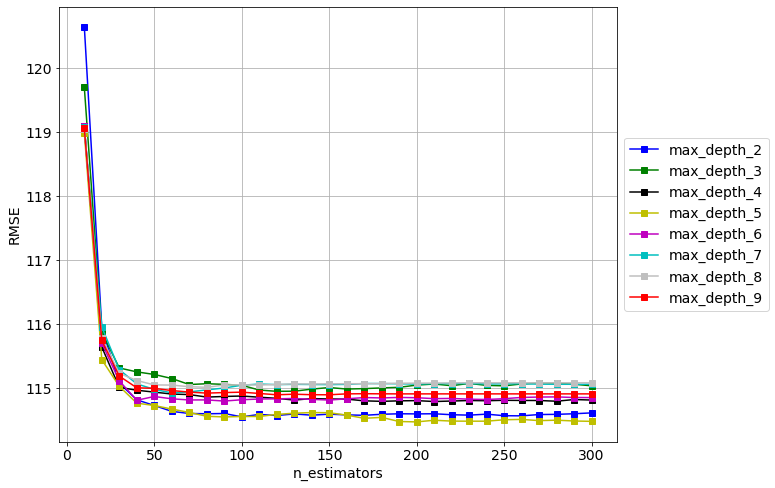

In [133]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [134]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
n_estimators_opt = temp['n_estimators'].values[0]
max_depth_opt = temp['max_depth'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
n_estimators_opt, max_depth_opt

min RMSE = 114.476
optimum params = 


(200, 5)

In [135]:
# Get optimum value for param and param2, using MAPE
temp = error_rate[error_rate['mape_pct'] == error_rate['mape_pct'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum params = ")
temp['n_estimators'].values[0], temp['max_depth'].values[0]

min MAPE = 4.148%
optimum params = 


(140, 3)

In [136]:
# Tuning XGBoost - learning_rate(default=0.1) and min_child_weight(default=1)
param_label = 'learning_rate'
param_list = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3]

param2_label = 'min_child_weight'
param2_list = range(5, 21, 1)

error_rate = {param_label: [] , param2_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm(param_list):
#     print("param = " + str(param))
    
    for param2 in param2_list:
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(X_train_scaled, 
                                     y_train_scaled, 
                                     X_cv_scaled, 
                                     y_cv, 
                                     cv['adj_close_mean'],
                                     cv['adj_close_std'],
                                     seed=model_seed,
                                     n_estimators=n_estimators_opt, 
                                     max_depth=max_depth_opt, 
                                     learning_rate=param, 
                                     min_child_weight=param2, 
                                     subsample=subsample, 
                                     colsample_bytree=colsample_bytree, 
                                     colsample_bylevel=colsample_bylevel, 
                                     gamma=gamma)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate

100%|██████████| 7/7 [00:20<00:00,  2.90s/it]

Minutes taken = 0.33793211380640664


,learning_rate,min_child_weight,rmse,mape_pct
0,0.001,5,135.207411,4.946359
1,0.001,6,135.192177,4.944653
2,0.001,7,135.180105,4.943814
3,0.001,8,135.166436,4.942547
4,0.001,9,135.162832,4.942124
...,...,...,...,...
107,0.300,16,115.270512,4.133738
108,0.300,17,116.011623,4.149843
109,0.300,18,115.916041,4.145453
110,0.300,19,116.063468,4.162587


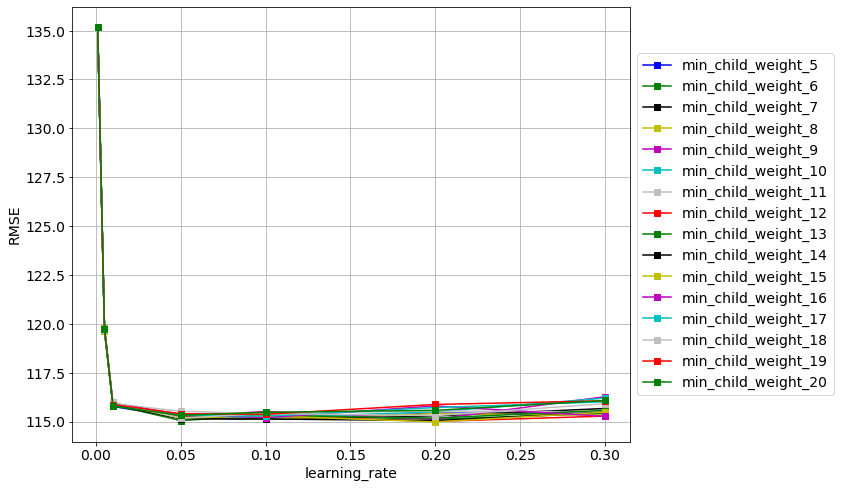

In [137]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [138]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
learning_rate_opt = temp['learning_rate'].values[0]
min_child_weight_opt = temp['min_child_weight'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
learning_rate_opt, min_child_weight_opt

min RMSE = 114.984
optimum params = 


(0.2, 15)

In [139]:
# Get optimum value for param and param2, using MAPE
# We will use RMSE to decide the final optimum params to use
temp = error_rate[error_rate['mape_pct'] == error_rate['mape_pct'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum params = ")
temp['learning_rate'].values[0], temp['min_child_weight'].values[0]

min MAPE = 4.126%
optimum params = 


(0.2, 18)

In [140]:
# Tuning XGBoost - subsample(default=1) and gamma(default=0)
param_label = 'subsample'
param_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

param2_label = 'gamma'
param2_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

error_rate = {param_label: [] , param2_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm(param_list):
#     print("param = " + str(param))
    
    for param2 in param2_list:
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(X_train_scaled, 
                                     y_train_scaled, 
                                     X_cv_scaled, 
                                     y_cv, 
                                     cv['adj_close_mean'],
                                     cv['adj_close_std'],
                                     seed=model_seed,
                                     n_estimators=n_estimators_opt, 
                                     max_depth=max_depth_opt, 
                                     learning_rate=learning_rate_opt, 
                                     min_child_weight=min_child_weight_opt, 
                                     subsample=param, 
                                     colsample_bytree=colsample_bytree, 
                                     colsample_bylevel=colsample_bylevel, 
                                     gamma=param2)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate

100%|██████████| 10/10 [00:17<00:00,  1.78s/it]

Minutes taken = 0.2968530138333639


,subsample,gamma,rmse,mape_pct
0,0.1,0.1,118.700236,4.306151
1,0.1,0.2,121.343306,4.384353
2,0.1,0.3,119.489201,4.340224
3,0.1,0.4,118.481343,4.282122
4,0.1,0.5,116.711532,4.203106
...,...,...,...,...
95,1.0,0.6,115.102575,4.155299
96,1.0,0.7,115.108111,4.165381
97,1.0,0.8,115.603337,4.146615
98,1.0,0.9,114.935415,4.141105


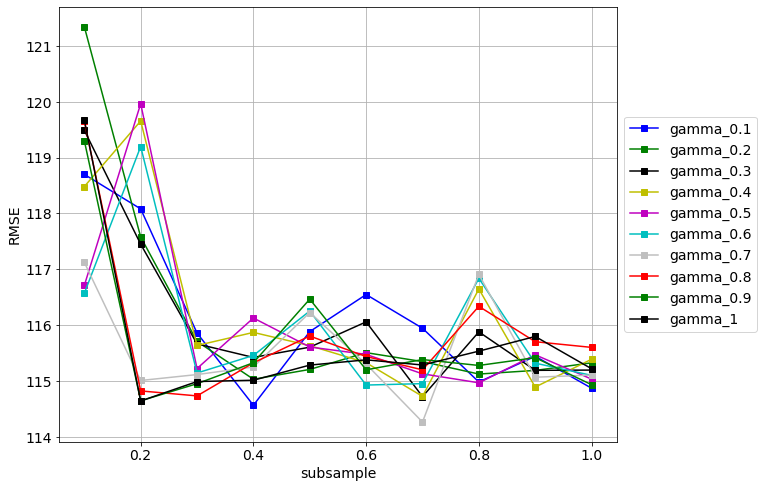

In [141]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [142]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
subsample_opt = temp['subsample'].values[0]
gamma_opt = temp['gamma'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
subsample_opt, gamma_opt

min RMSE = 114.267
optimum params = 


(0.7, 0.7)

In [143]:

# Get optimum value for param and param2, using MAPE
# We will use RMSE to decide the final optimum params to use
temp = error_rate[error_rate['mape_pct'] == error_rate['mape_pct'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum params = ")
temp['subsample'].values[0], temp['gamma'].values[0]

min MAPE = 4.088%
optimum params = 


(0.3, 0.5)

In [144]:
# Tuning XGBoost - colsample_bytree(default=1) and colsample_bylevel(default=1)
param_label = 'colsample_bytree'
param_list = [0.5, 0.6, 0.7, 0.8, 0.9, 1]

param2_label = 'colsample_bylevel'
param2_list = [0.5, 0.6, 0.7, 0.8, 0.9, 1]

error_rate = {param_label: [] , param2_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm(param_list):
#     print("param = " + str(param))
    
    for param2 in param2_list:
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(X_train_scaled, 
                                     y_train_scaled, 
                                     X_cv_scaled, 
                                     y_cv, 
                                     cv['adj_close_mean'],
                                     cv['adj_close_std'],
                                     seed=model_seed,
                                     n_estimators=n_estimators_opt, 
                                     max_depth=max_depth_opt, 
                                     learning_rate=learning_rate_opt, 
                                     min_child_weight=min_child_weight_opt, 
                                     subsample=subsample_opt, 
                                     colsample_bytree=param, 
                                     colsample_bylevel=param2, 
                                     gamma=gamma_opt)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate

100%|██████████| 6/6 [00:06<00:00,  1.08s/it]

Minutes taken = 0.10802445809046428


,colsample_bytree,colsample_bylevel,rmse,mape_pct
0,0.5,0.5,130.898945,4.893606
1,0.5,0.6,130.898945,4.893606
2,0.5,0.7,128.419197,4.792419
3,0.5,0.8,128.419197,4.792419
4,0.5,0.9,127.997283,4.739243
5,0.5,1.0,124.973529,4.642845
6,0.6,0.5,128.381485,4.822209
7,0.6,0.6,133.286717,5.081574
8,0.6,0.7,133.286717,5.081574
9,0.6,0.8,132.703717,5.032290


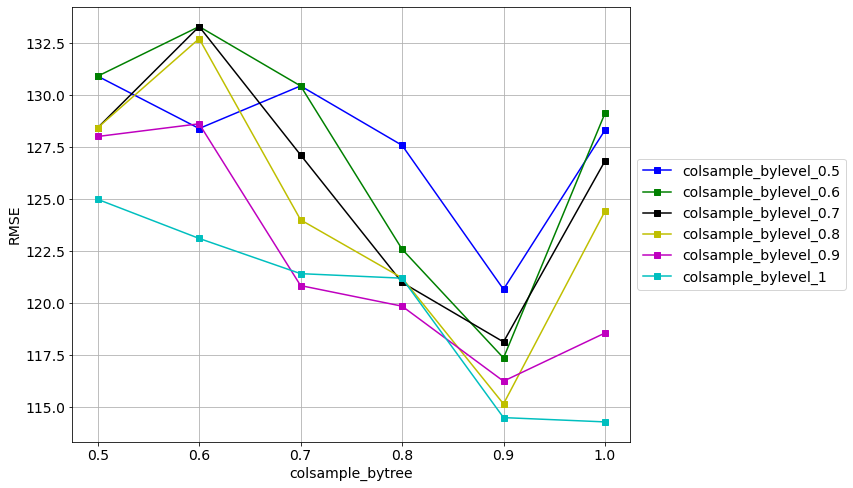

In [145]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [146]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
colsample_bytree_opt = temp['colsample_bytree'].values[0]
colsample_bylevel_opt = temp['colsample_bylevel'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
colsample_bytree_opt, colsample_bylevel_opt

min RMSE = 114.267
optimum params = 


(1.0, 1.0)

In [147]:

# Get optimum value for param and param2, using MAPE
# We will use RMSE to decide the final optimum params to use
temp = error_rate[error_rate['mape_pct'] == error_rate['mape_pct'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum params = ")
temp['colsample_bytree'].values[0], temp['colsample_bylevel'].values[0]

min MAPE = 4.144%
optimum params = 


(1.0, 1.0)

In [148]:
# Tuned params
d = {'param': ['n_estimators', 'max_depth', 'learning_rate', 'min_child_weight', 'subsample', 'colsample_bytree', 'colsample_bylevel', 'gamma', 'rmse', 'mape_pct'],
     'original': [n_estimators, max_depth, learning_rate, min_child_weight, subsample, colsample_bytree, colsample_bylevel, gamma, rmse_bef_tuning, mape_bef_tuning],
     'after_tuning': [n_estimators_opt, max_depth_opt, learning_rate_opt, min_child_weight_opt, subsample_opt, colsample_bytree_opt, colsample_bylevel_opt, gamma_opt, error_rate['rmse'].min(), error_rate['mape_pct'].min()]}
tuned_params = pd.DataFrame(d)
tuned_params = tuned_params.round(3)
tuned_params

,param,original,after_tuning
0,n_estimators,100.000,200.000
1,max_depth,3.000,5.000
2,learning_rate,0.100,0.200
3,min_child_weight,1.000,15.000
4,subsample,1.000,0.700
5,colsample_bytree,1.000,1.000
6,colsample_bylevel,1.000,1.000
7,gamma,0.000,0.700
8,rmse,115.048,114.267
9,mape_pct,4.151,4.144


In [149]:
# Final model
rmse, mape, est = train_pred_eval_model(X_train_cv_scaled, 
                             y_train_cv_scaled, 
                             X_sample_scaled, 
                             y_sample, 
                             test['adj_close_mean'],
                             test['adj_close_std'],
                             seed=model_seed,
                             n_estimators=n_estimators_opt, 
                             max_depth=max_depth_opt, 
                             learning_rate=learning_rate_opt, 
                             min_child_weight=min_child_weight_opt, 
                             subsample=subsample_opt, 
                             colsample_bytree=colsample_bytree_opt, 
                             colsample_bylevel=colsample_bylevel_opt, 
                             gamma=gamma_opt)

# Calculate RMSE
print("RMSE on test set = %0.3f" % rmse)

# Calculate MAPE
print("MAPE on test set = %0.3f%%" % mape)

RMSE on test set = 134.571
MAPE on test set = 3.495%


Text(0, 0.5, 'USD')

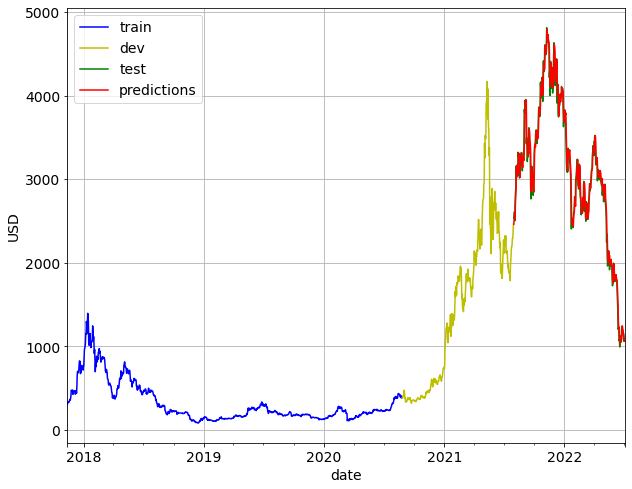

In [150]:

# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': est, 
                       'y_sample': y_sample,
                       'date': test['date']})

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

In [151]:
# # Plot adjusted close over time, for test set only
# rcParams['figure.figsize'] = 10, 8 # width 10, height 8
# ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
# ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
# ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
# ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
# ax.legend(['train', 'dev', 'test', 'predictions'])
# ax.set_xlabel("date")
# ax.set_ylabel("USD")
# # ax.set_xlim([date(2018, 4, 1), date(2020, 2, 28)])
# # ax.set_ylim([130, 155])
# ax.set_title("Zoom in to test set")

Text(0, 0.5, 'USD')

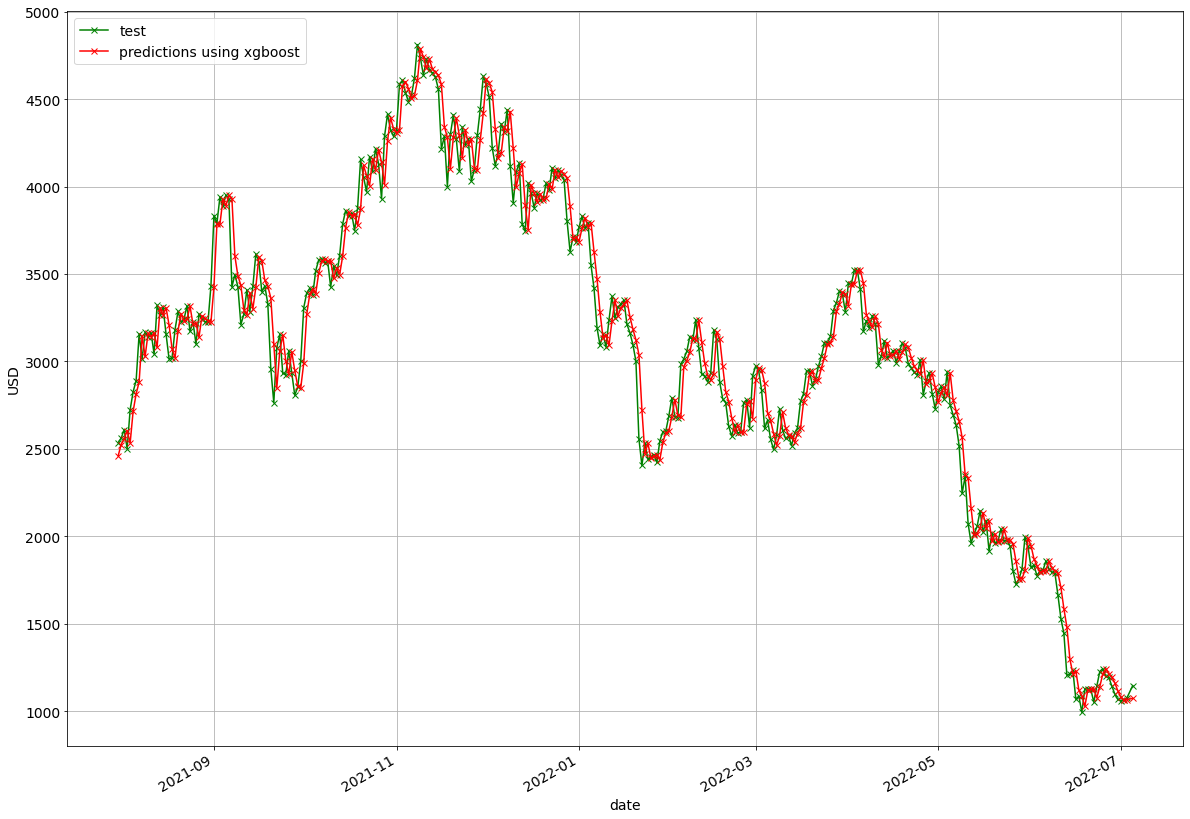

In [152]:
# Plot adjusted close over time, only for test set
rcParams['figure.figsize'] = 20, 15 # width 10, height 8
matplotlib.rcParams.update({'font.size': 14})

ax = test.plot(x='date', y='adj_close', style='gx-', grid=True)
ax = est_df.plot(x='date', y='est', style='rx-', grid=True, ax=ax)
ax.legend(['test', 'predictions using xgboost'], loc='upper left')
ax.set_xlabel("date")
ax.set_ylabel("USD")
# ax.set_xlim([date(2018, 4, 23), date(2018, 11, 23)])
# ax.set_ylim([130, 155])

In [153]:
# Save as csv
test_xgboost = est_df
test_xgboost.columns = [ 'Prediction','Close','Date']
test_xgboost.index=pd.to_datetime(test_xgboost['Date'])
test_xgboost=test_xgboost.drop(["Date"],axis=1)

test_xgboost.to_csv("../out/XGboost/ETH-USD.csv")
# test_xgboost



```
Findings
By scaling the features properly, we can get good results for our predictions
RMSE and MAPE changed very little with hyperparameter tuning
The final RMSE and MAPE for test set are 1.162 and 0.58% respectively
```

